In [55]:
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import torch.nn as nn

torch.manual_seed(2147483647)
device = torch.device("mps" if torch.mps.is_available() else "cpu")

In [56]:
names = pd.read_csv("names.txt",names = ["label"])
names.label[:5]

0        emma
1      olivia
2         ava
3    isabella
4      sophia
Name: label, dtype: object

#### Create Dataset

In [57]:
blocks = 3 # Number of blocks to pad the words
all_stoi = {} # Character to index mapping
all_itos ={} # Index to character mapping

def create_dataset(names):

    all = set("".join(names.label+"."))
    for index,(chr) in enumerate(sorted(all)):
        all_stoi[chr] = index

    for index,(chr) in enumerate(sorted(all)):
        all_itos[index] = chr


    x= []
    y = []
    for word in names.label:
        wx = [("."* (blocks - i)) + word  for i in range(blocks)]
        wy = [y.append(all_stoi[i]) for i in (word+".")]
                        
        for ch1,ch2,ch3 in zip(*wx[:len(wx)]):
            x.append((all_stoi[ch1],all_stoi[ch2],all_stoi[ch3]))



    x = torch.tensor(x)
    y = torch.tensor(y)

    return x, y

# Create train and test datasets
x, y = create_dataset(names)

train_x,val_x,train_y,val_y = train_test_split(x,y,test_size=0.2,shuffle=True,stratify = y,random_state=42)
val_x,test_x,val_y,test_y = train_test_split(val_x,val_y,test_size=0.1,stratify = val_y, random_state=42)

train_x,val_x,train_y,val_y = train_x.to(device),val_x.to(device),train_y.to(device),val_y.to(device)
val_x,test_x,val_y,test_y = val_x.to(device),test_x.to(device),val_y.to(device),test_y.to(device)




# print(f"train_x: {train_x.shape} train_y: {train_y.shape}") 
# print(f"val_x: {val_x.shape} val_y: {val_y.shape}")
# print(f"test_x: {test_x.shape} test_y: {test_y.shape}")

# Output:
# train_x: torch.Size([182516, 3]) train_y: torch.Size([182516])
# val_x: torch.Size([41067, 3]) val_y: torch.Size([41067])
# test_x: torch.Size([4563, 3]) test_y: torch.Size([4563])

#### 1) Notice: initial loss  

In [250]:
## Initialize excepectations
# like if we have 27 classes so then first training loss will be 
# All 27 classes will be equally distributed in the first training loss

# But here if we do not use multilpy the 0.01 or 0.1 to make smother weigths,bias something then the loss will be very high
# Epoch 0, Loss: 43.1070, Learning Rate: 0.001000





# 1/27 # this is chance 0.037037037037037035 that it equally on each classes

# -torch.tensor(1/27).log() # Compute loss,
# ouput: tensor(3.2958) # this is the expected loss for the first training step

#### Parameters + Training Loop

In [ ]:
# Parameters

neuron_node = 300
output_classes = 27  # 26 letters + 1 for '.'
emd_col_scale = 20  # Embedding column scale


# orginal parameter
c  = torch.nn.Parameter(torch.randn(output_classes, emd_col_scale, device=device) * 0.1) # Embedding matrix for characters

## total layer: 2
# 1 hidden layer
W  = torch.nn.Parameter(torch.randn(emd_col_scale * blocks, neuron_node, device=device) * ((5/3)/((emd_col_scale * blocks)**0.5 ))) # initlization external value to multiply gain/input
B  = torch.nn.Parameter(torch.zeros(neuron_node, device=device) )

# output Layer
W2 = torch.nn.Parameter(torch.randn(neuron_node, output_classes, device=device) * 0.01)
B2 = torch.nn.Parameter(torch.zeros(output_classes, device=device))


bngain = torch.ones(1,neuron_node,device=device)
bnbias = torch.ones(1,neuron_node,device=device)

bnstd_running = torch.ones(1,neuron_node,device=device)
bnmean_running = torch.zeros(1,neuron_node,device=device)

parameters = [c, W, B, W2, B2,bngain,bnbias]


# Optimizer + Scheduler
optimizer = torch.optim.Adam(parameters, lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50000)

# Tracking
lri = []
lossi = []
stepi = []


In [48]:
Epochs = 50000
batch_size = 512

# # Part of exmple: 2) notice
# z_tanh_vl ={}
# z_vl ={}

# Training loop
for epoch in range(1,Epochs+1):
    #  it is important to use mini-batches for faster training and better convergence
    mini_batchx = torch.randint(0,train_x.shape[0],(batch_size,), device = device) # mini batches make execution faster and boost the forward, backward pass
    # Forward pass
    emb = c[train_x[mini_batchx]] # Getting Embeddings 
    embed = emb.view(-1,emd_col_scale * blocks) # resizing for matrix multiplication

    z1 = embed @ W # + B # this B not required when you use batch normalization # One hidden layer with tanh activation

    # Batch Norm 
    bnmean = z1.mean(0,keepdims = True)
    bnstd = z1.std(0,keepdims = True)
    batch_norm = bngain *((z1 - bnmean)/bnstd) + bnbias + 0.05

    a1 = torch.tanh(batch_norm)
    logits = a1 @ W2+B2 # Output layer

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmean
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstd

        
    # Compute loss
    loss = F.cross_entropy(logits,train_y[mini_batchx])
    
    ## Backward pass
    # Optimizer step + scheduler step
    optimizer.zero_grad()  # Reset gradients
    loss.backward()  # Compute gradients
    optimizer.step() # Update parameters
    scheduler.step() # Update learning rate

    
    # Track stats
    lossi.append(loss.log10().item())
    # stepi.append(epoch)
    lri.append(scheduler.get_last_lr()[0])
    if epoch%10000 == 0:
        # z_vl[epoch] = z1 # Store the hidden layer output for visualization
        # z_tanh_vl[epoch] = a2  # Store the hidden layer output for visualization
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.6f}")



KeyboardInterrupt: 

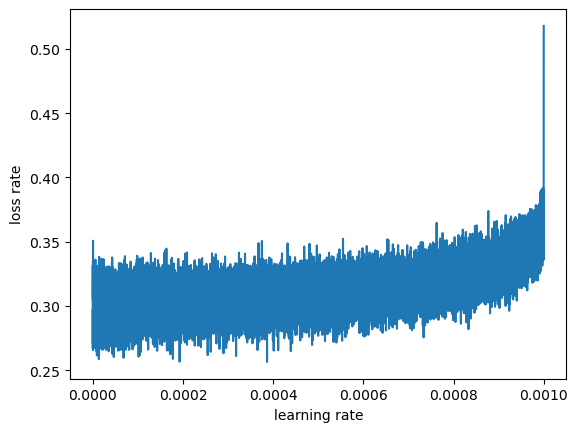

In [ ]:
plt.plot(lri,lossi)
plt.xlabel("learning rate")
plt.ylabel("loss rate")
plt.show()

<!-- Before batch normlization -->
Epoch 0, Loss: 3.2957, Learning Rate: 0.001000
Epoch 10000, Loss: 2.2032, Learning Rate: 0.000904
Epoch 20000, Loss: 2.0203, Learning Rate: 0.000654
Epoch 30000, Loss: 2.0451, Learning Rate: 0.000345
Epoch 40000, Loss: 2.0407, Learning Rate: 0.000095
Epoch 50000, Loss: 2.0367, Learning Rate: 0.000000
Epoch 60000, Loss: 1.8701, Learning Rate: 0.000096
Epoch 70000, Loss: 1.9707, Learning Rate: 0.000346
Epoch 80000, Loss: 1.9766, Learning Rate: 0.000655
Epoch 90000, Loss: 1.9081, Learning Rate: 0.000905

Validation Loss: 2.0736
Test Loss: 2.0944

<!-- After batch normlization -->
Epoch 10000, Loss: 2.1351, Learning Rate: 0.000905
Epoch 20000, Loss: 1.9842, Learning Rate: 0.000655
Epoch 30000, Loss: 2.0412, Learning Rate: 0.000345
Epoch 40000, Loss: 2.0378, Learning Rate: 0.000095
Epoch 50000, Loss: 2.0092, Learning Rate: 0.000000
Epoch 60000, Loss: 1.9303, Learning Rate: 0.000095
Epoch 70000, Loss: 1.9219, Learning Rate: 0.000345
Epoch 80000, Loss: 1.9779, Learning Rate: 0.000655
Epoch 90000, Loss: 1.9951, Learning Rate: 0.000905
Epoch 100000, Loss: 2.0546, Learning Rate: 0.001000

Validation Loss: 2.0880
Test Loss: 2.1121

#### 2) Notice: tanh activations rule and some things to understand

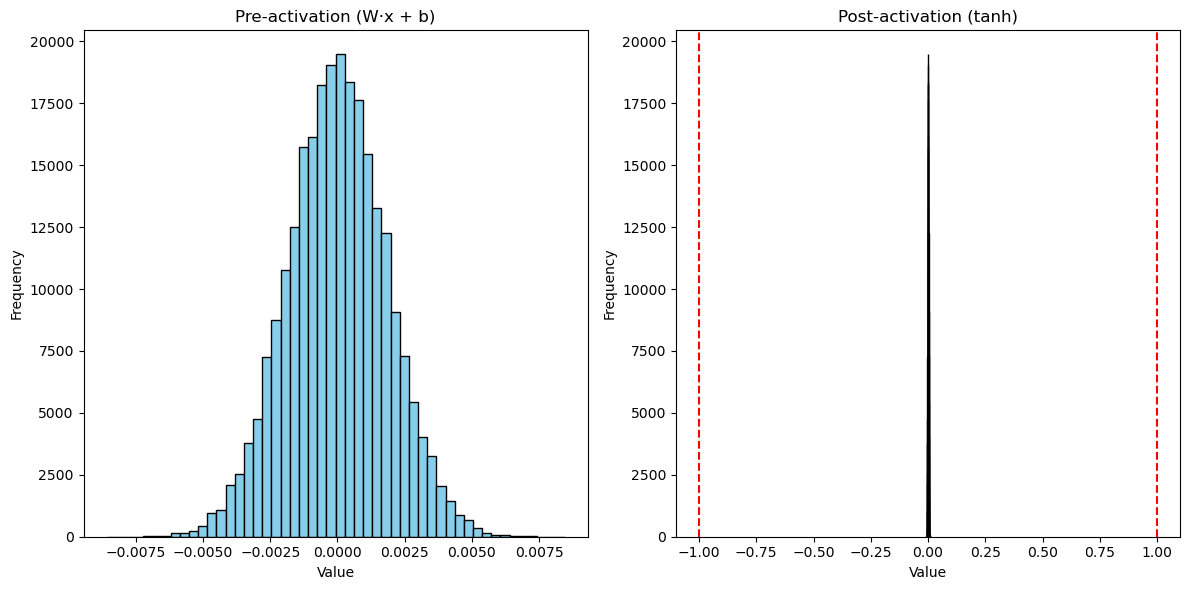

0.00022004976926837116
Weight update = 1.9999998807907104


In [ ]:
# if you want to execute this example
# so add this first to code in that parameter section above 


# tanh activation understanding
# c  = torch.nn.Parameter(torch.randn(output_classes, emd_col_scale, device=device) * 0.1) # Embedding matrix for characters

# W  = torch.nn.Parameter(torch.randn(emd_col_scale * blocks, neuron_node, device=device) * 0.01)
# B  = torch.nn.Parameter(torch.zeros(neuron_node, device=device))

# W2 = torch.nn.Parameter(torch.randn(neuron_node, neuron_node, device=device) * 0.01)
# B2 = torch.nn.Parameter(torch.zeros(neuron_node, device=device))

# W3 = torch.nn.Parameter(torch.randn(neuron_node, output_classes, device=device) * 0.01)
# B3 = torch.nn.Parameter(torch.zeros(output_classes, device=device))




# ------------------------------------------------------------------------------------------------------------------------------------------ #

# z[0]
fig,axes = plt.subplots(1,2,figsize=(12, 6))


# Left: pre-activation
axes[0].hist(z_vl[0].view(-1).tolist(), bins=50, color="skyblue", edgecolor="black")
axes[0].set_title("Pre-activation (W·x + b)")
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Frequency")

# Right: post-activation
axes[1].hist(z_tanh_vl[0].view(-1).tolist(), bins=50, color="lightgreen", edgecolor="black")
axes[1].set_title("Post-activation (tanh)")
axes[1].set_xlabel("Value")
axes[1].set_ylabel("Frequency")
axes[1].axvline(-1, color="red", linestyle="--")
axes[1].axvline(1, color="red", linestyle="--")

plt.tight_layout()
plt.show()



# so tanh activation function provides a 1 and -1 as the output
# and we can see that the values are mostly between -1 and 1 in the plots
# so when we backpropgate the loss calculate under the hood it will become 0 there so it does not affect the learning parameters with 

# Example
# formula link https://en.wikipedia.org/wiki/Hyperbolic_functions
x = 10.00
t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1) # this is tanh activation function 
# and the derivative is 1 - t**2



# so now i get the upper neual network tanh value and then I can use it to update the weights
# print(z_tanh_vl.items())
# print(z_tanh_vl[0][0])
print(z_tanh_vl[0][0][0].item())


# # Update this deravaitve of tanh activation function
derivative  = (1 - z_tanh_vl[0][0][0].item()**2) # deravaitive 1-t**2
# ouput: 1- 1.0**2 = 0.0

# # Example loss tensor
update = torch.tensor(derivative, dtype=torch.float32)   
Loss = torch.tensor(2.0, requires_grad=True)  
Loss.grad = torch.tensor(2.0, dtype=torch.float32)       # simulated incoming gradient

weight_update = torch.tensor(0.0) # so here you can see we initialize the weight update to 0 so if further any update occurs so it will be added
weight_update += update * Loss.grad # here you can see we multiply the update with the loss gradient
print("Weight update =", weight_update.item()) # output: 0.0

# so it wont update any weights and also occurs gradint vanishing problems



🚨 Gradients vanish → training slows or even stops.

If you scale weights down (e.g., multiply by 0.1) →

Pre-activation values stay closer to 0.

After passing through tanh, outputs stay in the linear region (around -0.5 to 0.5).

Derivatives remain large (~1), so gradients flow better.

What your histogram shows:

Left histogram (pre-activation): distribution centered tightly around 0.

Right histogram (post-activation): values all collapse very close to 0 instead of spreading out to -1 and 1.
This means your tanh is in its linear regime → gradients don’t vanish. ✅

In [ ]:
# if you want to execute this example
# so add this first to code in that parameter section above 


# tanh activation understanding
# c  = torch.nn.Parameter(torch.randn(output_classes, emd_col_scale, device=device)) # Embedding matrix for characters

# W  = torch.nn.Parameter(torch.randn(emd_col_scale * blocks, neuron_node, device=device))
# B  = torch.nn.Parameter(torch.zeros(neuron_node, device=device))

# W2 = torch.nn.Parameter(torch.randn(neuron_node, neuron_node, device=device))
# B2 = torch.nn.Parameter(torch.zeros(neuron_node, device=device))

# W3 = torch.nn.Parameter(torch.randn(neuron_node, output_classes, device=device))
# B3 = torch.nn.Parameter(torch.zeros(output_classes, device=device))





# ------------------------------------------------------------------------------------------------------------------------------------------ #

# z[0]
fig,axes = plt.subplots(1,2,figsize=(12, 6))


###### Left: pre-activation
axes[0].hist(z_vl[0].view(-1).tolist(), bins=50, color="skyblue", edgecolor="black")
axes[0].set_title("Pre-activation (W·x + b)")
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Frequency")

###### Right: post-activation
axes[1].hist(z_tanh_vl[0].view(-1).tolist(), bins=50, color="lightgreen", edgecolor="black")
axes[1].set_title("Post-activation (tanh)")
axes[1].set_xlabel("Value")
axes[1].set_ylabel("Frequency")
axes[1].axvline(-1, color="red", linestyle="--")
axes[1].axvline(1, color="red", linestyle="--")

plt.tight_layout()
plt.show()



# so tanh activation function provides a 1 and -1 as the output
# and we can see that the values are mostly between -1 and 1 in the plots
# so when we backpropgate the loss calculate under the hood it will become 0 there so it does not affect the learning parameters with 

# Example
x = 10.00
t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1) # this is tanh activation function derivative
#output: -0.7615941559557649



# so now i get the upper neual network tanh value and then I can use it to update the weights
# print(z_tanh_vl.items())
# print(z_tanh_vl[0][0])
print(z_tanh_vl[0][0][0].item())


# # Update this deravaitve of tanh activation function
derivative  = (1 - z_tanh_vl[0][0][0].item()**2) # deravaitive 1-t**2
# ouput: 1- 1.0**2 = 0.0

# # Example loss tensor
update = torch.tensor(derivative, dtype=torch.float32)   
Loss = torch.tensor(2.0, requires_grad=True)  
Loss.grad = torch.tensor(2.0, dtype=torch.float32)       # simulated incoming gradient

weight_update = torch.tensor(0.0) # so here you can see we initialize the weight update to 0 so if further any update occurs so it will be added
weight_update += update * Loss.grad # here you can see we multiply the update with the loss gradient
print("Weight update =", weight_update.item()) # output: 0.0

# so it wont update any weights and also occurs gradint vanishing problems



#### Testing on Datasets

In [285]:
# Test on test set + validation set
def test_model(dataset,name):
    with torch.no_grad():
        emb = c[dataset[0]] # Getting Embeddings on test set + valid set
        z1  = emb.view(emb.shape[0],-1) @ W + B # One hidden layer with tanh activation
        
        # batch norm
        # batch_norm = bngain *((z1 - bnmean_running)/bnstd_running) + bnbias
        
        a1 = torch.tanh(z1)

        logits = a1 @ W2+B2 # Output layer        
        # Compute loss
        loss = F.cross_entropy(logits,dataset[1])
        print(f"{name} Loss: {loss.item():.4f}")
      



val_dt = (val_x, val_y)
test_dt = (test_x, test_y)

test_model(val_dt,"Validation")
test_model(test_dt,"Test")


Validation Loss: 2.0736
Test Loss: 2.0944


#### Predict by Neural Network

In [ ]:
# predict the names
for _ in range(20):

    out=[]
    context = [0] * blocks
    while True:
        emb = c[torch.tensor([context])] 
        z = torch.tanh(emb.view(1,-1) @ W + B) 
        z1 = torch.tanh(z @ W2 + B2)
        logits = z1 @ W3+B3 
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).squeeze(1)
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(all_itos[i.item()] for i in out))



ana.
maine.
kimalyn.
makel.
dona.
noort.
marinah.
stenix.
ham.
jae.
rocka.
krise.
esmana.
avalon.
dayvon.
genia.
jens.
emonya.
pippa.
mordhealilia.


#### 3) Notice (optional): Batch Normalization

In [53]:
import matplotlib.image as mpimg

# Read the image
# img = mpimg.imread("Batch Norm on the paper.png")
# # Show in notebook
# plt.imshow(img)
# plt.axis("off")  # Hide axes
# plt.show()


## ALl formula are listed in the image 
## add in Parameters 
# bngain = torch.ones(1,neuron_node,device=device)
# bnbias = torch.ones(1,neuron_node,device=device)

## Add in training Loop
## Batch Norm
# bnmean = z1.mean(0,keepdims = True)

# bnstd = z1.std(0,keepdims = True)
# batch_norm = bngain *((z1 - bnmean)/bnstd) + bnbias

# Concepts:
# https://chatgpt.com/share/68a716c5-557c-8012-b998-388e05745f4f

# 

In [44]:
# the data has 10 numbers
# now the bins is making the normal distribution chances like 
# bins = 2 ,data =10
# so it make the bins=tensor([-1.3808, 0.3409,  1.94])

# and then make pairs of bins by length given 
# [-1.3808, 0.3409]
# [ 0.3409,  1.94]

# and then it checks the data which values fall in 
# 1) first chance
# or
# 2) second chance


# counts = tensor([7., 3.])

# so now the 7 values under the 1) chance
# remains are 2) chance


In [ ]:
## Make a pytorchfying code

# class MLPai:
#     def __init__(self,fan_in,fan_out,bias=True):
#         self.weight = torch.randn(fan_in,fan_out) /fan_in ** 0.05 # this is square root of fan in ,(kaiming technique)
#         self.bias = torch.zeros(fan_out) if bias else None

#         self.all_layer = torch.nn.Sequential(
#             torch.nn.Linear(x,fan_out),
#             batch_norm
#             nn.Tanh(),

#             torch.nn.Linear(fan_out,fan_out),
#             nn.Tanh(),

#             torch.nn.Linear(fan_out,27),
#         )

#     def 


class Linear:
    def __init__(self,fan_in,fan_out,bias = True):
        self.weights = torch.randn(fan_in,fan_out)
        self.bias = torch.zeros(fan_out) if bias else None 


    def __call__(self,x):
        self.out = x @ self.weights
        self.out += self.bias if self.bias is not None else None
        return self.out

    def parameter(self):
        return [self.weights] + [self.bias] if self.bias is not None else []


class BatchNorm1d:
    def __init__(self,dim,epsilion=1e-5,momentum = 0.1):
        self.epsilion = epsilion
        self.momentum = momentum

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0,keepdim = True) # each one batch have calculate mean of that inside content
            xstd = x.mean(0,keepdim = True) # each one batch have calculate std of that inside content
        else:
            xmean = self.running_mean 
            xstd = self.running_std 

        xhat = (x-xmean) / (torch.sqrt(xstd + self.epsilion))
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xstd

        return self.out
    

    def parameter(self):
        return [self.gamma,self.beta] 


class Tanh:
    def __call__(self,x):
        return torch.tanh(x)
    def parameter(self):
        return [] 


n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
vocab_size = len(all_itos)
lr = 0.001

C = torch.randn(vocab_size, n_embd)
layers = [
  Linear(n_embd * blocks, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weights *= 1.0 #5/3    


parameter = [C] + [p for layer in layers for p in layer.parameter()]
print(sum(p.nelement() for p in parameter)) # number of parameters in total
for p in parameter:
  p.requires_grad = True


optimizer = torch.optim.SGD(parameter,lr = lr)


1324


In [ ]:
# same optimization as last time
Epochs = 50000 + 50000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max = Epochs)

batch_size = 32
lossi = []
ud = []


for epoch in range(Epochs):

    batching = torch.randint(0 ,train_x.shape[0],(batch_size,))
    tx,ty = train_x[batching],train_y[batching]

    # forward pass
    embedding = C[tx] # embed the characters into vectors
    x = embedding.view(embedding.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, ty) # loss function
  
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
     
    # Track Stats
    if epoch % 1000 == 0:
        print(f"Epoch: {epoch} || loss: {loss.item()} ")
    lossi.append(loss.log10().item())
    with torch.no_grad:
        ud.append([((lr*p.grad).std()/ p.data.std()).log10().item() for p in parameter])

    print(tx.shape)
    print("\n\n\n\n\n\n\n")
    print(batching)
    print("\n\n\n\n\n\n\n")
    print(tx)
    
    if epoch >= 10000:
        break

RuntimeError: indices should be either on cpu or on the same device as the indexed tensor (cpu)